# **Text Classification on BERT**

## Bidirectional Encoder Representations from Transformers (BERT)

BERT, short for Bidirectional Encoder Representations from Transformers, is a cutting-edge natural language processing (NLP) model that has revolutionized the field of machine learning. Developed by Google, BERT utilizes a deep transformer architecture to u**nderstand the contextual nuances of words in sentences**, enabling it to grasp the meaning of text comprehensively. Its pre-trained nature on vast text corpora, coupled with fine-tuning capabilities, makes it a versatile and powerful tool for a wide range of NLP tasks, from sentiment analysis to question answering, and has significantly advanced the state-of-the-art in language understanding and generation tasks.




In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/Semester 3/Transformers Tutorial/new_BERT_Overall.jpg", width=1200)


## BERT for Text Classification
BERT, a multi-layer bidirectional transformer encoder, stands out for its deep text comprehension capabilities, **considering the full context of words in sentences**. Its pre-trained nature involves training on vast text data, making it proficient in language understanding. Fine-tuning for specific NLP tasks further enhances its accuracy. We concentrate on BERT base, offering substantial context comprehension with reduced computational requirements, making it an excellent choice for text classification tasks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing necessary libraries**

In [ ]:
!pip install transformers

In [ ]:
# Provides functions for interacting with the operating system
import os

# For GPU access and various neural network functionalities
import torch

**Loading Training data and Preprocessing it**

In [ ]:
# For data manipulation and analysis
import pandas as pd


# Read the CSV file 'IMDB Dataset.csv' into a DataFrame and store it in the variable 'df'
df = pd.read_csv('/content/drive/MyDrive/Semester 3/Transformers Tutorial/IMDB Dataset.csv')
print(df)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [ ]:
# Extracting the 'review' column from the DataFrame and converting it to a list
texts = df['review'].tolist()

# Creating labels based on the 'sentiment' column, where 'positive' is mapped to 1 and 'negative' to 0
labels = [1 if sentiment == "positive" else 0 for sentiment in df['sentiment'].tolist()]

**Prepare data for text classification model**

* First divide the dataset into two subsets: one for training and the other for validation in 80-20 ratio.
* Then initialize a BERT tokenizer specific to the chosen model and uses it to tokenize the training and validation texts.
* Tokenized texts are organized into datasets along with their corresponding labels.
* Data is loaded into dataloaders, making it suitable for model training.

This process sets up the data pipeline for training and evaluation of the BERT text classification model.

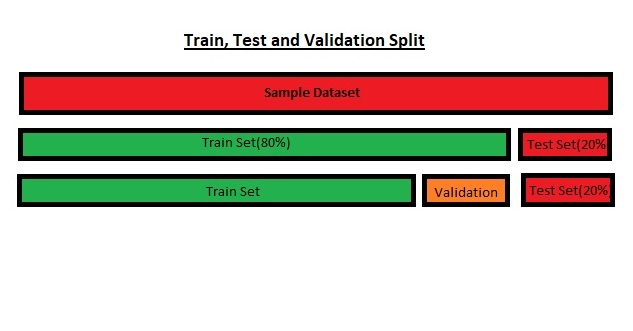

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/Semester 3/Transformers Tutorial/datasplit.jpeg", width=800)

In [ ]:
# For data splitting
from sklearn.model_selection import train_test_split


# Splitting the data into train and test sets, with 80% for training and 20% for testing
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Further splitting the training data into train and validation sets, leaving 60% for training and 20% for validation
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


The TextClassificationDataset class is designed to create a custom dataset for text classification tasks. It takes in texts, corresponding labels, a tokenizer, and a maximum sequence length as input. The class allows you to specify the length of the dataset, access individual data samples, and preprocess the text data using the provided tokenizer. It returns a dictionary containing input IDs, attention masks, and labels for each data sample, making it compatible with PyTorch's DataLoader for training and evaluation in text classification model.

In [ ]:
# custom dataset class for text classification tasks.

# For working with BERT-based models and optimization
from transformers import BertTokenizer
from torch.utils.data import Dataset

# Define the name of the BERT model to be used
bert_model_name = 'bert-base-uncased'

# Define the maximum length of input sequences (e.g., maximum number of tokens)
max_length = 128

# Initialize a BERT tokenizer using the specified pretrained model name.
tokenizer = BertTokenizer.from_pretrained(bert_model_name)


class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        # Initialize the dataset with texts, corresponding labels, tokenizer, and maximum sequence length.
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Return the total number of samples in the dataset.
        return len(self.texts)

    def __getitem__(self, idx):
        # Retrieve a single sample by its index.
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize and preprocess the text sample using the tokenizer.
        encoding = self.tokenizer(
            text,
            return_tensors='pt',  # Return PyTorch tensors.
            max_length=self.max_length,  # Truncate or pad text to the specified max length.
            padding='max_length',  # Pad sequences to have the same length.
            truncation=True  # Truncate sequences if they exceed the max length.
        )

        # Return the tokenized input IDs, attention mask, and corresponding label.
        return {
            'input_ids': encoding['input_ids'].flatten(),  # Flatten the input IDs tensor.
            'attention_mask': encoding['attention_mask'].flatten(),  # Flatten the attention mask tensor.
            'label': torch.tensor(label)  # Convert the label to a PyTorch tensor.
        }


In [ ]:
#sample tokenization

tokenizer = BertTokenizer.from_pretrained(bert_model_name)
text = "This movies is one of the best production I have seen in years. "

encoding = tokenizer(
            text,
            return_tensors='pt',  # Return PyTorch tensors.
            max_length=max_length,  # Truncate or pad text to the specified max length.
            padding='max_length',  # Pad sequences to have the same length.
            truncation=True  # Truncate sequences if they exceed the max length.
        )
print("Tokeniser arguments:",encoding.keys())
print("\nTokeniser Result size:",encoding["input_ids"].shape)
print("\nInput ids:",encoding['input_ids'])
print("\nToken type ids:",encoding['token_type_ids'])
print("\nAttention mask:",encoding['attention_mask'])

Tokeniser arguments: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Tokeniser Result size: torch.Size([1, 128])

Input ids: tensor([[ 101, 2023, 5691, 2003, 2028, 1997, 1996, 2190, 2537, 1045, 2031, 2464,
         1999, 2086, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0, 

In [ ]:
# Get the input IDs and tokens
input_ids = encoding['input_ids'][0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Print the tokens and their corresponding input IDs
for token, input_id in zip(tokens, input_ids):
    print(f"Token: {token}\t Input ID: {input_id}")
    if input_id ==0:
      break


Token: [CLS]	 Input ID: 101
Token: this	 Input ID: 2023
Token: movies	 Input ID: 5691
Token: is	 Input ID: 2003
Token: one	 Input ID: 2028
Token: of	 Input ID: 1997
Token: the	 Input ID: 1996
Token: best	 Input ID: 2190
Token: production	 Input ID: 2537
Token: i	 Input ID: 1045
Token: have	 Input ID: 2031
Token: seen	 Input ID: 2464
Token: in	 Input ID: 1999
Token: years	 Input ID: 2086
Token: .	 Input ID: 1012
Token: [SEP]	 Input ID: 102
Token: [PAD]	 Input ID: 0


In [ ]:
# Create a training dataset by tokenizing the training texts and labels using the tokenizer,
# ensuring a maximum length for input sequences.
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)

# Create a validation dataset by tokenizing the validation texts and labels using the tokenizer,
# ensuring a maximum length for input sequences.
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)

In [ ]:
# For handling data loading and batching
from torch.utils.data import DataLoader

# Define the batch size for training data (number of examples processed together)
batch_size = 16

# Create a DataLoader for the training dataset to handle batching and shuffling.
# The batch size is specified by 'batch_size', and shuffling the data is useful for training.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation dataset without shuffling, as validation doesn't require shuffling.
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

**Classifier over BERT base model**


 The BERTClassifier class is a text classification model. It utilizes the pre-trained BERT model to extract contextual embeddings from input text. The class includes a dropout layer to prevent overfitting and a fully connected layer (fc) for classification. In the forward method, it takes input IDs and attention masks, processes them through the BERT model, and then applies dropout to the pooled output. Finally, it computes class logits using the fully connected layer.

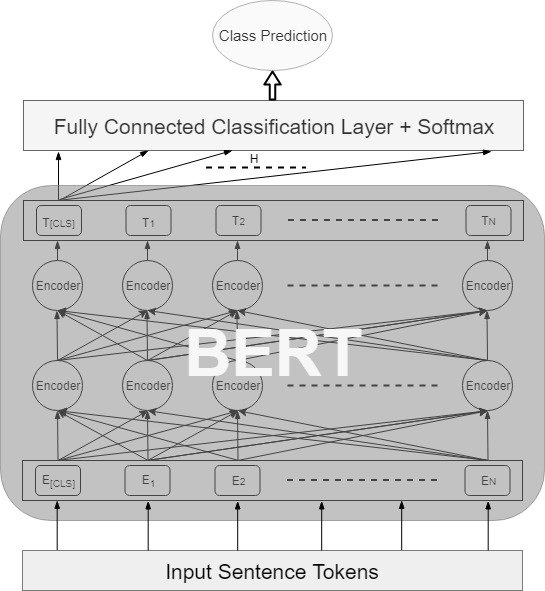

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/Semester 3/Transformers Tutorial/BERT-Fine-Tuning-Model-Architecture.png")

In [ ]:
# Define a custom classifier model using BERT as a base.

# Neural network related modules and functions
from torch import nn
from transformers import BertModel


class BERTClassifier(nn.Module):
    # Initialize the model.
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()

        # Load the pre-trained BERT model from the specified model name.
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Add a dropout layer to prevent overfitting (with dropout rate 0.1).
        self.dropout = nn.Dropout(0.1)

        # Add a fully connected layer (linear layer) for classification.
        # The input size is the hidden size of BERT, and the output size is the number of classes.
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    # Define the forward pass of the model.
    def forward(self, input_ids, attention_mask):
        # Pass the input IDs and attention mask through the BERT model.
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the hidden states (representations) of each token from the last layer.
        hidden_states = outputs.last_hidden_state

        # Get the pooled representation (CLS token) from the BERT model.
        pooled_output = outputs.pooler_output

        # Apply dropout to the pooled representation.
        x = self.dropout(pooled_output)

        # Pass the dropout output through the fully connected layer for classification.
        logits = torch.sigmoid(self.fc(x))

        # Return both the logits (output of the classifier) and the hidden states.
        return logits, hidden_states


**The train funct**ion

The `train()` function accepts the model, data loader, optimizer, scheduler, and device as its inputs. It starts by setting the model to training mode and then iterates through each batch of data provided by the data loader. Within each batch, it resets the optimizer's gradients, retrieves the input IDs, attention masks, and labels, and subsequently forwards them to the model for processing.

In [ ]:
# Function for training the model
def train(model, data_loader, optimizer, scheduler, device):
    # Set the model to training mode
    model.train()

    # Iterate through each batch in the data loader
    for batch in data_loader:
        # Zero out the gradients in the optimizer
        optimizer.zero_grad()

        # Move input data to the specified device (e.g., GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through the model to get predictions
        outputs, _ = model(input_ids=input_ids, attention_mask=attention_mask)

        # Calculate the loss using CrossEntropyLoss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Perform backpropagation to compute gradients
        loss.backward()

        # Update model parameters using the optimizer
        optimizer.step()

        # Adjust learning rate using the scheduler
        scheduler.step()

**Evaluation**

The evaluate() function assesses model's performance. It calculates the model's predictions for input data, compares them to actual labels, and computes the accuracy of these predictions. Additionally, it generates a detailed classification report, including metrics like precision, recall, F1-score, and support for each class. This function is essential for understanding how well a model is classifying data.

In [ ]:
# This function evaluates a given model on a dataset using the specified device.

# For data splitting and evaluation
from sklearn.metrics import accuracy_score, classification_report


def evaluate(model, data_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize empty lists to store predictions and actual labels
    predictions = []
    actual_labels = []

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over batches in the data loader
        for batch in data_loader:
            # Move input data and labels to the specified device (CPU or GPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass through the model to obtain predictions
            outputs, _ = model(input_ids=input_ids, attention_mask=attention_mask)

            # Compute the predicted class labels by taking the argmax of the output scores
            _, preds = torch.max(outputs, dim=1)

            # Extend the predictions and actual labels lists with batch results
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    # Calculate accuracy and generate a classification report based on actual vs. predicted labels
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)


In [ ]:
# Define the number of classes for the sentiment analysis task (here, positive and negative)
num_classes = 2

# Check if CUDA (GPU) is available, and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the BERTClassifier model, specifying the BERT model name and number of output classes,
# and move the model to the selected device (either GPU or CPU)
model = BERTClassifier(bert_model_name, num_classes).to(device)

# The 'model' variable now contains the BERTClassifier model, ready for further operations or training
model

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the number of training epochs (how many times the model goes through the entire dataset)
num_epochs = 5

# Define the learning rate for the optimizer (controls the step size during training)
learning_rate = 2e-5


# Initialize the optimizer with the model's parameters and a specified learning rate
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Calculate the total number of training steps by multiplying the number of batches
# in the training dataloader with the number of training epochs
total_steps = len(train_dataloader) * num_epochs

# Create a learning rate scheduler that linearly increases the learning rate for a certain number
# of warm-up steps and then decreases it linearly for the remaining training steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Train model and save**

In [ ]:
# Iterate through a specified number of epochs
accurary_array = []

for epoch in range(num_epochs):
    # Display the current epoch number
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Perform training using the 'train' function and update model parameters
    train(model, train_dataloader, optimizer, scheduler, device)

    # Evaluate the model's performance on the validation dataset and calculate accuracy and report
    accuracy, report = evaluate(model, val_dataloader, device)

    # Display the validation accuracy for the current epoch
    print(f"Validation Accuracy: {accuracy:.4f}")

    #append current accuracy to the array
    accurary_array.append(accuracy)

    # Print a classification report summarizing model performance
    print(report)


Epoch 1/5
Validation Accuracy: 0.8790
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4937
           1       0.89      0.87      0.88      5063

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Epoch 2/5
Validation Accuracy: 0.8806
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      4937
           1       0.85      0.93      0.89      5063

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Epoch 3/5
Validation Accuracy: 0.8834
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4937
           1       0.91      0.85      0.88      5063

    accuracy                           0.88     10000
   macro avg  

In [ ]:
# Save the state dictionary of the 'model' to a file named "bert_text_classifier.pth"
torch.save(model.state_dict(), "/content/drive/MyDrive/Semester 3/Transformers Tutorial/bert_text_classifier_imdb.pth")

**Evaluating our model’s performance**

In [ ]:
#load the saved model GPU
load_model = BERTClassifier(bert_model_name, num_classes).to(device)
load_model.load_state_dict(torch.load('/content/drive/MyDrive/Semester 3/Transformers Tutorial/bert_text_classifier_imdb.pth'), strict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
#load the saved model CPU
load_model = BERTClassifier(bert_model_name, num_classes)
load_model.load_state_dict(torch.load('/content/drive/MyDrive/Semester 3/Transformers Tutorial/bert_text_classifier_imdb.pth', map_location='cpu'), strict=False)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['bert.embeddings.position_ids'])

In [ ]:
#Evaluation On Test Dataset
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
accuracy, report = evaluate(load_model, test_dataloader, device)
print(f"Test Accuracy: {accuracy:.4f}")
print(report)

Test Accuracy: 0.8899
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4961
           1       0.89      0.89      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000






**Prediction Function**

The function utilizes the fine-tuned model for sentiment analysis. In evaluation mode, it takes a text input, a model, tokenizer, and other optional parameters like device and maximum length. The function encodes the input text, ensuring it meets the specified maximum length, and then runs the model on this input. It retrieves the model's prediction and interprets it as either "positive" or "negative" sentiment. This function simplifies sentiment analysis tasks by providing a quick way to classify text as either positive or negative.

In [ ]:
# Define a function to predict sentiment using the provided model and tokenizer
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    # Put the model in evaluation mode
    model.eval()

    # Tokenize and encode the input text
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)

    # Move the input tensors to the specified device (e.g., GPU)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Perform forward pass (prediction) without gradient computation
    with torch.no_grad():
        outputs,_ = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    # Map the prediction to sentiment label (e.g., 1 for positive, 0 for negative)
    if preds.item() == 1:
      sentiment = "positive"
    else:
       sentiment = "negative"

    # Print the input text and predicted sentiment
    print(f"Text: {text}, \n Predicted sentiment: {sentiment}\n")


In [ ]:
# Test sentiment analysis
import random
for i in range(5):
    text = random.choice(test_texts)
    predict_sentiment(text, load_model, tokenizer, device)

Text: Finally, an indie film that actually delivers some great scares! I see most horror films that come out... Theatrical, Straight-To-DVD, cable, etc... and most of them suck... a few are watchable... even fewer are actually good... Dark Remains is one of the good ones. I caught a screening of this film at the South Padre Island Film Festival... the audience loved it... and my wife and I loved it! Having no name actors, I assume the budget on this film was pretty low, but you wouldn't know it... the film looks fantastic... the acting totally works for the film... the story is good... and the scares are great! While most filmmakers focus solely on the scares, they often forget about story and character development, two things that help to deliver the scares more efficiently. Brian Avenet-Bradley must know that character and story are important. He develops both to the point where you care about the characters, you know the characters, and are therefore more scared when they are in dan

In [ ]:
text ="I am sure this is a masterpiece from the director"
predict_sentiment(text, load_model, tokenizer, device)

Text: I am sure this is a masterpiece from the director, 
 Predicted sentiment: positive



# References


- Image courtsey: Google
- Khang Pham, Text Classification with BERT [link](https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b)
- Devlin et al, BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding, ACL'19  [link](https://aclanthology.org/N19-1423.pdf)
- scikit-learn: https://scikit-learn.org/stable/
- PyTorch: https://pytorch.org/
